In [31]:
!pip install boruta xgboost imblearn
#, mlflow, optuna, boto3

In [32]:
!pip install mlflow boto3 awscli optuna

In [33]:
!pip install optuna

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import RFE, SelectFromModel, mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from boruta import BorutaPy

import time
import os

from joblib import Parallel, delayed
from collections import Counter

import warnings
from sklearn.exceptions import ConvergenceWarning

from pathlib import Path

warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Data Loading

In [35]:
secom_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
X = pd.read_csv(secom_data_url, sep=' ', header=None)
feature_names = [f'feature{i+1}' for i in range(X.shape[1])]
X.columns = feature_names
X.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [4]:
X.shape

(1567, 590)

In [36]:
secom_labels_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_csv(secom_labels_url, sep=' ', header=None)
label_columns = ['label', 'date_time']
y.columns = label_columns
y['label'] = y['label'].replace(-1, 0)
y.head()

,label,date_time
0,0,19/07/2008 11:55:00
1,0,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,0,19/07/2008 14:43:00
4,0,19/07/2008 15:22:00


In [8]:
y.shape

(1567, 2)

In [9]:
y['label'].value_counts(normalize=True)

label
0    0.933631
1    0.066369
Name: proportion, dtype: float64

## Train-Test Split and initial analysis

In [38]:
# 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y['label'],
    random_state=42
)

In [39]:
# Check the sizes of the resulting datasets
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Training set size: 1253, Test set size: 314


In [41]:
# Checking Class Distributions after splitting the data
print('Original label distribution: ')
print(y['label'].value_counts(normalize=True))

print('\nTraining label distribution: ')
print(y_train['label'].value_counts(normalize=True))

print('\nTest label distribution: ')
print(y_test['label'].value_counts(normalize=True))

Original label distribution: 
label
0    0.933631
1    0.066369
Name: proportion, dtype: float64

Training label distribution: 
label
0    0.933759
1    0.066241
Name: proportion, dtype: float64

Test label distribution: 
label
0    0.933121
1    0.066879
Name: proportion, dtype: float64


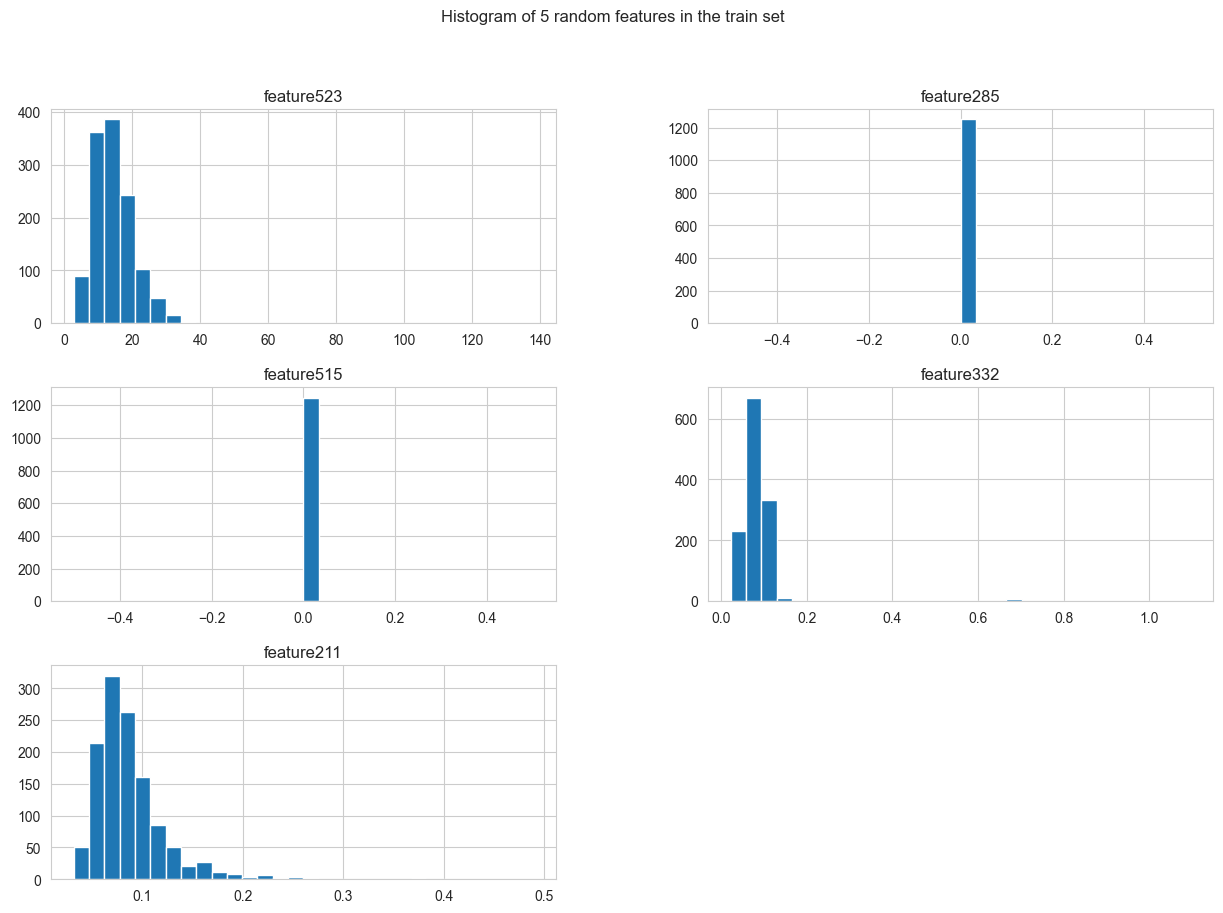

In [9]:
X_train.sample(5, axis=1, random_state=42).hist(bins=30, figsize=(15, 10))
plt.suptitle('Histogram of 5 random features in the train set')
plt.show()

In [42]:
# Checking for duplicate rows
duplicates = X_train.duplicated()

# Count the number of duplicates
no_of_duplicates = duplicates.sum()
print(f'Number of duplicated rows in X_train: {no_of_duplicates}')

Number of duplicated rows in X_train: 0


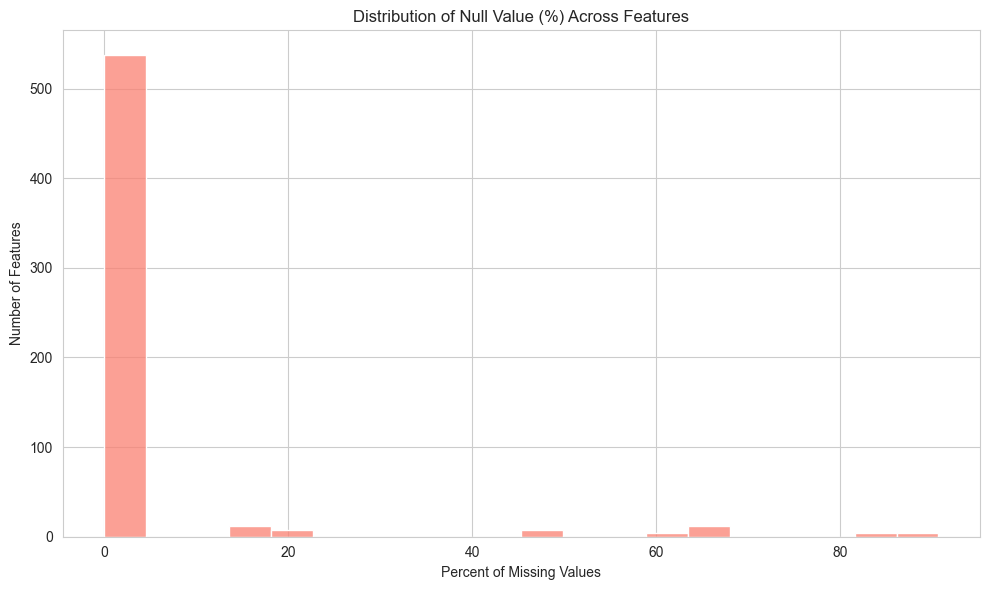

In [43]:
# Distribution of Null Values across features
missing_percent_per_feature = (X_train.isnull().sum() / len(X_train)) * 100

plt.figure(figsize=(10,6))
sns.histplot(missing_percent_per_feature, bins=20, kde=False, color='salmon')
plt.title('Distribution of Null Value (%) Across Features')
plt.xlabel('Percent of Missing Values')
plt.ylabel('Number of Features')
plt.tight_layout()
plt.show()

Based on the viz above we can cleary see a huge jump from around 20% to 45% in the percent of missing value in a feature. Based on this, we've decided to choose our threshold of 45% and features that have this percent of missing values or higher will be removed from the data.

In [44]:
len(missing_percent_per_feature[missing_percent_per_feature > 45])

32

In [45]:
len(X_train.nunique()[X_train.nunique() == 1])

116

There are 32 features that have a high percent of missing values and there are 116 features that have 0 volatility.

In [46]:
y_train_arr = y_train.drop(columns='date_time')
y_train_arr = y_train_arr.to_numpy().ravel()

In [47]:
y_test.head()

,label,date_time
246,0,18/08/2008 04:35:00
1315,0,05/10/2008 09:47:00
444,0,24/08/2008 07:12:00
296,0,19/08/2008 08:07:00
1295,0,04/10/2008 18:25:00


## Implementation

## Creating a custom wrapper that preserves the output as a DF. Using it for Imputation methods for now. Can be used elsewhere

In [48]:
class DataFramePreserver(BaseEstimator, TransformerMixin):
    def __init__(self, transformer):
        # Store the wrapped transformer
        self.transformer = transformer
        self.columns_ = None
        self.index_ = None

    def fit(self, X, y=None):
        # Save columns and index if input is a DataFrame
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
            self.index_ = X.index
        # Fit the underlying transformer
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        # Apply the underlying transform
        X_t = self.transformer.transform(X)
        # Return a DataFrame with original columns and index
        return pd.DataFrame(X_t, columns=self.columns_, index=X.index)

## DropHighNullAndConstantFeatures class

In [49]:
class DropHighNullAndConstantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, null_threshold=0.45):
        # Threshold for dropping columns with too many nulls
        self.null_threshold = null_threshold

    def fit(self, X, y=None):
        # Calculate fraction of nulls per feature
        null_ratio_per_feature = X.isnull().mean()

        # Identify features with null ratio above threshold
        self.too_null_features_ = null_ratio_per_feature[
            null_ratio_per_feature > self.null_threshold
        ].index.tolist()

        # Identify constant features (including all-NaN columns with 0 unique values)
        self.constant_features_ = [col for col in X.columns if X[col].nunique() <= 1]

        # Combine features to drop
        self.features_to_drop_ = list(
            set(self.too_null_features_ + self.constant_features_)
        )

        return self

    def transform(self, X):
        # Drop identified features, ignoring errors if columns are missing
        return X.drop(columns=self.features_to_drop_, errors='ignore')

## Temporarily scales the data before applying the imputation method

In [50]:
class ScaledImputerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, imputer, scaler=None, apply_scaling=True):
        # Store imputer and scaler (default RobustScaler), and whether to apply scaling
        self.imputer = imputer
        self.scaler = scaler if scaler else RobustScaler()
        self.apply_scaling = apply_scaling

    def fit(self, X, y=None):
        X = pd.DataFrame(X)  # Ensure input is DataFrame for consistency
        if self.apply_scaling:
            # Fit scaler then imputer on scaled data
            self.scaler.fit(X)
            X_scaled = self.scaler.transform(X)
            self.imputer.fit(X_scaled)
        else:
            # Fit imputer directly on data without scaling
            self.imputer.fit(X)
        return self

    def transform(self, X):
        X = pd.DataFrame(X)  # Ensure input is DataFrame for consistency
        if self.apply_scaling:
            # Scale, impute missing values, then inverse scale to restore original scale
            X_scaled = self.scaler.transform(X)
            X_imputed = self.imputer.transform(X_scaled)
            X_restored = self.scaler.inverse_transform(X_imputed)
            return pd.DataFrame(X_restored, columns=X.columns, index=X.index)
        else:
            # Impute missing values without scaling
            X_imputed = self.imputer.transform(X)
            return pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

## Class implementing Outlier Capping

In [51]:
class OutlierCapping(BaseEstimator, TransformerMixin):
    def __init__(self, zscore_threshold=3):
        # Threshold for z-score to cap outliers
        self.zscore_threshold = zscore_threshold
        self.means_ = None
        self.stds_ = None

    def fit(self, X, y=None):
        X = X.copy()
        # Calculate and store mean and std deviation of features
        self.means_ = X.mean()
        self.stds_ = X.std()
        return self

    def transform(self, X):
        X = X.copy()
        # Cap numeric feature values at mean ± zscore_threshold * std
        for col in X.select_dtypes(include=[np.number]).columns:
            mean = self.means_[col]
            std = self.stds_[col]
            lower = mean - self.zscore_threshold * std
            upper = mean + self.zscore_threshold * std
            X[col] = np.clip(X[col], lower, upper)
        return X

## Class implementing multiple Feature Selection methods

In [73]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, method='rfe', estimator=None, n_features_to_select=None, fraction_to_select=0.1, n_estimators=1000, max_iter=500):
        # Initialize selector parameters and method choice
        self.method = method
        self.estimator = estimator
        self.n_features_to_select = n_features_to_select
        self.fraction_to_select = fraction_to_select
        self.n_estimators = n_estimators
        self.max_iter = max_iter

    def fit(self, X, y):
        X = np.array(X)  # Ensure numpy array input

        if self.method == 'rfe':
            # Default estimator if none provided (balanced RF classifier)
            if self.estimator is None:
                self.estimator = RandomForestClassifier(
                    n_estimators=1000, min_samples_leaf=5,
                    class_weight='balanced_subsample', max_depth=15,
                    n_jobs=-1, random_state=42
                )
            # Determine number of features to select if not set
            if self.n_features_to_select is None:
                self.n_features_to_select = int(X.shape[1] * self.fraction_to_select)

            # Use Recursive Feature Elimination with the estimator
            self.selector_ = RFE(estimator=clone(self.estimator), n_features_to_select=self.n_features_to_select)

        elif self.method == 'lasso':
            # Use Lasso for feature selection (regression)
            # Could swap with LogisticRegression for classification with L1 penalty
            self.selector_ = SelectFromModel(Lasso(alpha=0.01, random_state=42))

        elif self.method == 'boruta':
            # Boruta feature selector wrapper
            if self.estimator is None:
                self.estimator = RandomForestClassifier(
                    n_estimators=1000, min_samples_leaf=5,
                    class_weight='balanced_subsample', max_depth=15,
                    n_jobs=-1, random_state=42
                )
            self.selector_ = BorutaPy(
                estimator=clone(self.estimator),
                n_estimators='auto',
                perc=80,
                random_state=42,
            )
        else:
            raise ValueError("Unsupported method. Use 'rfe', 'lasso' or 'boruta'.")

        self.selector_.fit(X, y)  # Fit the chosen selector
        return self

    def transform(self, X):
        # Ensure fit was called before transform
        if not hasattr(self, 'selector_'):
            raise RuntimeError("You must fit the transformer before calling transform.")
        return self.selector_.transform(np.array(X))

    def get_support(self):
        # Ensure fit was called before get_support
        if not hasattr(self, 'selector_'):
            raise RuntimeError("fit() must be called before get_support().")

        # Boruta exposes support_ attribute directly
        if self.method == 'boruta':
            return self.selector_.support_

        # RFE and Lasso use get_support() method
        return self.selector_.get_support()

## Display class distributions after balancing

In [74]:
class DebugTargetStats(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # If target y is provided, print class distribution counts
        if y is not None:
            counts = np.bincount(y)
            print(f"[Debug] Class distribution after balancing: Negative={counts[0]}, Positive={counts[1]}")
        return self

    def transform(self, X):
        # Pass data through unchanged
        return X

## If you want to skip adding a component within the pipeline

In [75]:
class NoOperation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting needed, return self
        return self

    def transform(self, X):
        # Return input unchanged
        return X

## Function to create our imbalanced pipeline and set the steps

In [76]:
def create_pipeline(imp_name, imputer, fs_name, selector, bal_name, balancer,
                    model, apply_scaling = False):
  steps = []

  # 1. Drop features with too many nulls or no variance
  steps.append(('preprocess', DropHighNullAndConstantFeatures()))

  # 2. Imputation (wrapped with ScaledImputerWrapper)
  steps.append(('impute', DataFramePreserver(imputer)))

  # 3. Outlier capping (on original/unscaled values)
  #steps.append(('cap', OutlierCapping()))

  # 4. Final scaling (if needed for selector or model)
  if apply_scaling:
    steps.append(('scale', DataFramePreserver(RobustScaler())))

  # 5. Feature selection
  steps.append(('select', selector))

  # 6. Balancing
  steps.append(('balance', balancer))

  # 7. Optional step to check class balance after resampling
  debug_step = DebugTargetStats() if bal_name != 'none' else NoOperation()
  steps.append(('debug', debug_step))

  # 8. Model
  steps.append(('clf', model))

  # Logging the pipeline steps
  print("\nFinal Pipeline steps:")
  for name, step in steps:
    print(f" - {name}: {step}")

  return ImbPipeline(steps)

## Pipeline Components

In [79]:
# Since XGB doesn't have class_weight='balanced', we need to define one that can be used
custom_class_weight = float(y_train['label'].value_counts()[0] / y_train['label'].value_counts()[1])

# Define pipeline components
imputers = {
    # "none": lambda: NoOperation(),
    #"median": lambda: ScaledImputerWrapper(SimpleImputer(strategy="median"), apply_scaling=False),
    "knn": lambda: ScaledImputerWrapper(KNNImputer(), apply_scaling=True),
    "mice": lambda: ScaledImputerWrapper(IterativeImputer(random_state=42), apply_scaling=True)
}

feature_selectors = {
    # "none": lambda: NoOperation(),
    "rfe": lambda: FeatureSelector(method='rfe'),
    "lasso": lambda: FeatureSelector(method='lasso'),
    "boruta": lambda: FeatureSelector(method='boruta'),
}

balancers = {
    # "none": lambda: NoOperation(),
    "smote": lambda: SMOTE(random_state=42),
    "adasyn": lambda: ADASYN(random_state=42),
    "rose": lambda: RandomOverSampler(random_state=42)
}

models = {
    #"none": lambda: NoOperation(),
    # "RandomForest": lambda: RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_leaf=5, random_state=42, n_jobs=-1),
    # "LogisticRegression": lambda: LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    # "SVC": lambda: SVC(probability=True, random_state=42), # try LinearSVC or use SVC with some kernel like rbf, rbf is default btw
    # "XGB": lambda: XGBClassifier(
    #     max_depth=6, n_estimators=300, subsample=0.8, colsample_bytree=0.8,
    #     learning_rate=0.05, eval_metric='logloss', random_state=42, n_jobs=-1
    #     ),
    # "SVC_test": lambda **params: SVC(random_state=42, **params)
    "LogReg_test": lambda **params: LogisticRegression(random_state=42, **params)
    # "XGB_test": lambda **params: XGBClassifier(random_state=42, **params),
    # "CalibratedRF": lambda: CalibratedClassifierCV(
    #     estimator=RandomForestClassifier(
    #         n_estimators=300, max_depth=15,
    #         min_samples_leaf=3, class_weight='balanced',
    #         random_state=42, n_jobs=-1
    #     ),
    #     method='isotonic',
    #     cv=3
    #   )
}

## Experimentation

In [84]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "SVC_BEST"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [83]:
def log_results(new_results, path="experiment_SVC_best_gridsearch.csv"):
    # Load existing results if file exists
    if os.path.exists(path):
        existing_df = pd.read_csv(path)
        # Append new results to existing ones
        combined_df = pd.concat([existing_df, pd.DataFrame(new_results)], ignore_index=True)
    else:
        # Create new DataFrame if no existing file
        combined_df = pd.DataFrame(new_results)

    # Save combined results back to CSV
    combined_df.to_csv(path, index=False)
    print(f"Logged {len(new_results)} results to {path}")

In [82]:

results = []

test_mode = True

if test_mode:
  test_combinations = [
      # ('knn', 'none', 'rose',	'none',	'RandomForest',	True),
      # ('knn', 'none',	'adasyn',	'none',	'RandomForest',	True),
      # ('knn', 'none',	'smote',	'none',	'RandomForest',	True),
      # ('mice',	'none',	'smote',	'none',	'RandomForest',	True),

      ('mice',	'rfe',	'rose', 'SVC_test'),
      # ('knn',	'rfe',	'smote', 'XGB')

      # ('mice',	'lasso',	'adasyn',	'none',	'RandomForest',	True),
      # ('mice',	'rfe',	'adasyn',	'none',	'RandomForest',	True),
      # ('mice',	'none',	'adasyn',	'none',	'RandomForest',	True),
      # ('mice',	'boruta',	'rose',	'none',	'RandomForest',	True),
      # ('mice',	'lasso',	'rose',	'none',	'RandomForest',	True),
      # ('mice',	'rfe',	'rose',	'none',	'RandomForest',	True),
      # ('mice',	'none',	'rose',	'none',	'RandomForest',	True),
      # ('mice',	'boruta',	'none',	'none',	'RandomForest',	True),
      # ('mice',	'lasso',	'none',	'none',	'RandomForest',	True),
      # ('mice',	'rfe',	'none',	'none',	'RandomForest',	True),
      # ('mice',	'none',	'none',	'none',	'RandomForest',	True),
  ]

else:
  test_combinations =[
    (imp, fs, bal, model)
    for imp in imputers
    for fs in feature_selectors
    for bal in balancers
    for model in models
  ]


# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'min_child_weight': [1, 3, 5]
}



# Replace the XGB model generator with tuned model
best_xgb_params = grid_search.best_params_
models['XGB'] = lambda: XGBClassifier(**best_xgb_params, use_label_encoder=False, random_state=42, n_jobs=-1)
for imp_name, fs_name, bal_name, model_name in test_combinations:
  # Fresh components for each fold
  imputer = imputers[imp_name]()
  selector = feature_selectors[fs_name]()
  balancer = balancers[bal_name]()
  model = models[model_name]()
  apply_scaling = True
  try:
    # Define the pipeline name for logging
    name = f"{imp_name}_{fs_name}_{bal_name}_{model_name}_{apply_scaling}"
    print(f"\nTraining {name}...")

    start_time = time.time()

    pipe = create_pipeline(imp_name, imputer, fs_name, selector,
                           bal_name, balancer, model, apply_scaling)

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_proba = cross_val_predict(pipe, X_train, y_train_arr, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    sns.histplot(y_proba[y_train_arr == 0], color='blue', label='Negative class', stat='density', bins=30)
    sns.histplot(y_proba[y_train_arr == 1], color='red', label='Positive class', stat='density', bins=30)
    plt.xlabel('Predicted Probability')
    plt.title('Predicted Probabilities by Class')
    plt.legend()
    plt.show()

    # Compute precision, recall, thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_train_arr, y_proba)

    # Avoid division by zero
    eps = 1e-10
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + eps)
    
    beta2 = 2
    f2_scores = (1 + beta2**2) * (precisions * recalls) / ((beta2**2 * precisions) + recalls + eps)

    # Get the best threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    best_precision = precisions[best_idx]
    best_recall = recalls[best_idx]

    # Get the best F2 threshold
    best_idx_f2 = np.argmax(f2_scores)
    best_threshold_f2 = thresholds[best_idx_f2]
    best_f2 = f2_scores[best_idx_f2]
    best_precision_f2 = precisions[best_idx_f2]
    best_recall_f2 = recalls[best_idx_f2]
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_train_arr, y_proba)
    
    # Visualize the P-R curve
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisions[:-1], label=f'Precision = {best_precision_f2:.3f}')
    plt.plot(thresholds, recalls[:-1], label=f'Recall = {best_recall_f2:.3f}')
    plt.plot(thresholds, f1_scores[:-1], label=f'F1 Score = {best_f1:.3f}', color='black')
    plt.plot(thresholds, f2_scores[:-1], label=f'F2 Score = {best_f2:.3f}', color='green')
    plt.axvline(best_threshold, linestyle='--', color='red', label=f'Best Threshold = {best_threshold:.3f}')
    plt.axvline(best_threshold_f2, linestyle='--', color='green', label=f'Best F2 Threshold = {best_threshold_f2:.3f}')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision, Recall, and F1 vs. Threshold for {name}")
    plt.legend()
    plt.grid(True)
    save_fig(f"{name}_pr_curve")
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_train_arr, y_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name}: ROC Curve")
    plt.legend()
    plt.grid(True)
    save_fig(f"{name}_roc_curve")
    plt.show()

    # Confusion Matrix
    y_pred = (y_proba >= best_threshold).astype(int)
    cm = confusion_matrix(y_train_arr, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good Wafers", "Faulty Wafers"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix based on the f1 threshold for {name}")
    plt.grid(False)
    save_fig(f"{name}_confusion_matrix")
    plt.show()
    
    # Confusion Matrix based on F2 threshold
    y_pred_f2 = (y_proba >= best_threshold_f2).astype(int)
    cm2 = confusion_matrix(y_train_arr, y_pred_f2)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["Good Wafers", "Faulty Wafers"])
    disp2.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix based on the f2 threshold for {name}")
    plt.grid(False)
    save_fig(f"{name}_confusion_matrix_f2")
    plt.show()

    # Hybrid approach to get feature counts
    # feature_counts=[]
    # for train_idx, val_idx in cv.split(X_train, y_train_arr):
    #     X_tr, y_tr = X_train.iloc[train_idx], y_train_arr[train_idx]
    #     print('\n ----------------------------------------------------------------------------')
    #     print(f"Train Valid split done and finding the count of features selected by {fs_name}")
    # 
    #     # Use pipeline with "none" model for feature selection only
    #     pipe = create_pipeline(imp_name, imputer, fs_name, selector,
    #                        bal_name, balancer, models["none"](), apply_scaling)
    # 
    #     pipe.fit(X_tr, y_tr)
    # 
    #     n_features = pipe.named_steps['select'].get_support().sum()
    #     feature_counts.append(n_features)

    # Measure execution time
    execution_time = round(time.time() - start_time, 2)

    results.append({
      'Pipeline': name,
      'Best_Threshold_F1': round(best_threshold, 4),
      'F1': round(best_f1, 4),
      'Precision': round(best_precision, 4),
      'Recall': round(best_recall, 4),
      'Best_Threshold_F2': round(best_threshold_f2, 4),
      'F2': round(best_f2, 4),
      'Precision_F2': round(best_precision_f2, 4),
      'Recall_F2': round(best_recall_f2, 4),
      'ROC_AUC': round(roc_auc, 4),
      # 'Mean_of_Features_Selected': round(np.mean(feature_counts), 2),
      # 'Std_of_Features_Selected': round(np.std(feature_counts), 2),
      'Execution_Time_s': execution_time
    })
    log_results(results)


  except Exception as e:
    print(f"Pipeline {name} failed: {e}")


Training mice_rfe_rose_SVC_test_True...

Final Pipeline steps:
 - preprocess: DropHighNullAndConstantFeatures()
 - impute: DataFramePreserver(transformer=ScaledImputerWrapper(imputer=IterativeImputer(random_state=42),
                                                    scaler=RobustScaler()))
 - scale: DataFramePreserver(transformer=RobustScaler())
 - select: FeatureSelector()
 - balance: RandomOverSampler(random_state=42)
 - debug: DebugTargetStats()
 - clf: SVC(random_state=42)


KeyboardInterrupt: 

In [ ]:
log_results(results)

In [ ]:
import optuna

# Step 6: Optuna objective function for XGBoost
def objective_xgboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)

    model_params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'eval_metric': 'logloss'
    }

    # Build pipeline with trial hyperparams
    pipe = create_pipeline(
        imp_name='knn',  # or other fixed/preferred
        imputer=imputers['knn'](),
        fs_name='boruta',
        selector=feature_selectors['boruta'](),
        bal_name='smote',
        balancer=balancers['smote'](),
        model=models["XGB_test"](**model_params),
        apply_scaling=True
    )

    # Cross-validate and compute mean F1
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_proba = cross_val_predict(pipe, X_train, y_train_arr, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_train_arr, y_proba)
    eps = 1e-10
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + eps)
    best_f1 = np.max(f1_scores)

    return best_f1


# Step 7: Run Optuna for XGBoost, log the best model only
def run_optuna_and_evaluate():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgboost, n_trials=30)

    # Get the best parameters and log only the best model
    best_params = study.best_params
    print("Best hyperparameters:", best_params)

    final_model_params = {
        'n_estimators': best_params['n_estimators'],
        'learning_rate': best_params['learning_rate'],
        'max_depth': best_params['max_depth'],
        'eval_metric': 'logloss'
    }

    # Build final pipeline
    final_pipe = create_pipeline(
        imp_name='knn',
        imputer=imputers['knn'](),
        fs_name='boruta',
        selector=feature_selectors['boruta'](),
        bal_name='smote',
        balancer=balancers['smote'](),
        model=models['XGB_test'](**final_model_params),
        apply_scaling=True
    )

    # Fit pipeline on full training set
    final_pipe.fit(X_train, y_train_arr)

    # Predict probabilities and evaluate
    y_proba = final_pipe.predict_proba(X_train)[:, 1]

    # Precision-recall curve and best threshold
    precisions, recalls, thresholds = precision_recall_curve(y_train_arr, y_proba)
    eps = 1e-10
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + eps)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    best_precision = precisions[best_idx]
    best_recall = recalls[best_idx]
    roc_auc = roc_auc_score(y_train_arr, y_proba)

    # Plot P-R curves and F1
    # plt.figure(figsize=(8, 5))
    # plt.plot(thresholds, precisions[:-1], label=f'Precision = {best_precision:.3f}')
    # plt.plot(thresholds, recalls[:-1], label=f'Recall = {best_recall:.3f}')
    # plt.plot(thresholds, f1_scores[:-1], label=f'F1 Score = {best_f1:.3f}', color='black')
    # plt.axvline(best_threshold, linestyle='--', color='red', label=f'Best Threshold = {best_threshold:.3f}')
    # plt.xlabel("Threshold")
    # plt.ylabel("Score")
    # plt.title("Precision, Recall, and F1 vs. Threshold (Final Model)")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # Plot ROC Curve
    # fpr, tpr, _ = roc_curve(y_train_arr, y_proba)
    # plt.figure(figsize=(6, 6))
    # plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.4f})', color='blue')
    # plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title("ROC Curve (Final Model)")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # Confusion Matrix
    # y_pred = (y_proba >= best_threshold).astype(int)
    # cm = confusion_matrix(y_train_arr, y_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good Wafers", "Faulty Wafers"])
    # disp.plot(cmap=plt.cm.Blues)
    # plt.title("Confusion Matrix (Final Model)")
    # plt.grid(False)
    # plt.show()

    return final_pipe

    # Log the best model with MLflow, passing the algo_name as "xgboost"
    # log_mlflow("XGBoost", best_model, X_train, X_test, y_train, y_test)

# Run the experiment for XGBoost


In [87]:
# Optuna objective function for SVC
def objective_lr(trial):
    # Modify the hyperparams below to appropriate ones for LogReg
    C = trial.suggest_loguniform('C', 1e-2, 1e2)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    
    model_params = {
        'C': C,
        'gamma': gamma,
        'kernel': kernel,
        'degree': degree
    }

    # Build pipeline
    # Manually put in the imp_name, fs_name etc that gave you the best F2 for LogReg
    pipe = create_pipeline(
        imp_name='mice',
        imputer=imputers['mice'](),
        fs_name='rfe',
        selector=feature_selectors['rfe'](),
        bal_name='rose',
        balancer=balancers['rose'](),
        model=models["LogReg_test"](**model_params),
        apply_scaling=True
    )

    # Cross-validate and compute mean F2
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_proba = cross_val_predict(pipe, X_train, y_train_arr, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_train_arr, y_proba)
    eps = 1e-10
    
    beta2 = 2
    f2_scores = (1 + beta2**2) * (precisions * recalls) / ((beta2**2 * precisions) + recalls + eps)
    best_f2 = np.max(f2_scores)

    return best_f2


# Run Optuna for SVC, log the best model only
def run_optuna_and_evaluate():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_lr, n_trials=30)

    # Get the best parameters and log only the best model
    best_params = study.best_params
    print("Best hyperparameters:", best_params)
    
    start_time = time.time()

    # Build final pipeline
    # Agin manually put in the imp_name, fs_name etc that gave you the best F2 for LogReg
    final_pipe = create_pipeline(
        imp_name='mice',
        imputer=imputers['mice'](),
        fs_name='rfe',
        selector=feature_selectors['rfe'](),
        bal_name='rose',
        balancer=balancers['rose'](),
        model=models["LogReg_test"](**best_params),
        apply_scaling=True
    )
    
    # Change the name accordingly
    name = "mice_rfe_rose_LR_best_True"

    # Fit pipeline on full training set
    final_pipe.fit(X_train, y_train_arr)

    # Predict probabilities and evaluate
    y_proba = final_pipe.predict_proba(X_train)[:, 1]
    
    # Compute precision, recall, thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_train_arr, y_proba)

    # Avoid division by zero
    eps = 1e-10
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + eps)
    
    beta2 = 2
    f2_scores = (1 + beta2**2) * (precisions * recalls) / ((beta2**2 * precisions) + recalls + eps)

    # Get the best threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    best_precision = precisions[best_idx]
    best_recall = recalls[best_idx]

    # Get the best F2 threshold
    best_idx_f2 = np.argmax(f2_scores)
    best_threshold_f2 = thresholds[best_idx_f2]
    best_f2 = f2_scores[best_idx_f2]
    best_precision_f2 = precisions[best_idx_f2]
    best_recall_f2 = recalls[best_idx_f2]
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_train_arr, y_proba)
    
    # Visualize the P-R curve
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisions[:-1], label=f'Precision = {best_precision_f2:.3f}')
    plt.plot(thresholds, recalls[:-1], label=f'Recall = {best_recall_f2:.3f}')
    plt.plot(thresholds, f1_scores[:-1], label=f'F1 Score = {best_f1:.3f}', color='black')
    plt.plot(thresholds, f2_scores[:-1], label=f'F2 Score = {best_f2:.3f}', color='green')
    plt.axvline(best_threshold, linestyle='--', color='red', label=f'Best Threshold = {best_threshold:.3f}')
    plt.axvline(best_threshold_f2, linestyle='--', color='green', label=f'Best F2 Threshold = {best_threshold_f2:.3f}')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision, Recall, and F1 vs. Threshold for {name}")
    plt.legend()
    plt.grid(True)
    save_fig(f"{name}_pr_curve_best")
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_train_arr, y_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name}: ROC Curve")
    plt.legend()
    plt.grid(True)
    save_fig(f"{name}_roc_curve_best")
    plt.show()

    # Confusion Matrix based in F1 threshold
    y_pred = (y_proba >= best_threshold).astype(int)
    cm = confusion_matrix(y_train_arr, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good Wafers", "Faulty Wafers"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix based on the f1 threshold for {name}")
    plt.grid(False)
    save_fig(f"{name}_confusion_matrix_f1_best")
    plt.show()
    
    # Confusion Matrix based on F2 threshold
    y_pred_f2 = (y_proba >= best_threshold_f2).astype(int)
    cm2 = confusion_matrix(y_train_arr, y_pred_f2)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["Good Wafers", "Faulty Wafers"])
    disp2.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix based on the f2 threshold for {name}")
    plt.grid(False)
    save_fig(f"{name}_confusion_matrix_f2_best")
    plt.show()
    
    # Measure execution time
    execution_time = round(time.time() - start_time, 2)

    results.append({
      'Pipeline': name,
      'Best_Threshold_F1': round(best_threshold, 4),
      'F1': round(best_f1, 4),
      'Precision': round(best_precision, 4),
      'Recall': round(best_recall, 4),
      'Best_Threshold_F2': round(best_threshold_f2, 4),
      'F2': round(best_f2, 4),
      'Precision_F2': round(best_precision_f2, 4),
      'Recall_F2': round(best_recall_f2, 4),
      'ROC_AUC': round(roc_auc, 4),
      'Execution_Time_s': execution_time
    })
    
    log_results(results)

    return final_pipe

In [86]:
best_lr_pipe = run_optuna_and_evaluate()

[I 2025-07-10 00:05:17,577] A new study created in memory with name: no-name-c11b87f2-6a61-4b69-86d9-634f35756f15
/var/folders/cq/0fxss7jx4pdb14ytj0zbbywh0000gp/T/ipykernel_93829/1821988741.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)
/var/folders/cq/0fxss7jx4pdb14ytj0zbbywh0000gp/T/ipykernel_93829/1821988741.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
[W 2025-07-10 00:05:17,625] Trial 0 failed with parameters: {'C': 8.005056852055075, 'gamma': 0.0016746235293720229, 'kernel': 'rbf'} because of the following error: TypeError("SVC.__init__() got an unexpected

TypeError: SVC.__init__() got an unexpected keyword argument 'gamam'

In [ ]:
def evaluate_on_test(final_pipe, X_test, y_test_arr):
    # Again put in the correct name
    name = "mice_rfe_rose_LR_best_True"
    
    # Predict probabilities on test set
    y_proba_test = final_pipe.predict_proba(X_test)[:, 1]

    # Compute precision, recall, thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test_arr, y_proba_test)

    # Avoid division by zero
    eps = 1e-10
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + eps)
    
    beta2 = 2
    f2_scores = (1 + beta2**2) * (precisions * recalls) / ((beta2**2 * precisions) + recalls + eps)

    # Get the best threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    best_precision = precisions[best_idx]
    best_recall = recalls[best_idx]

    # Get the best F2 threshold
    best_idx_f2 = np.argmax(f2_scores)
    best_threshold_f2 = thresholds[best_idx_f2]
    best_f2 = f2_scores[best_idx_f2]
    best_precision_f2 = precisions[best_idx_f2]
    best_recall_f2 = recalls[best_idx_f2]
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_train_arr, y_proba)
    
    # Visualize the P-R curve
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisions[:-1], label=f'Precision = {best_precision_f2:.3f}')
    plt.plot(thresholds, recalls[:-1], label=f'Recall = {best_recall_f2:.3f}')
    plt.plot(thresholds, f1_scores[:-1], label=f'F1 Score = {best_f1:.3f}', color='black')
    plt.plot(thresholds, f2_scores[:-1], label=f'F2 Score = {best_f2:.3f}', color='green')
    plt.axvline(best_threshold, linestyle='--', color='red', label=f'Best Threshold = {best_threshold:.3f}')
    plt.axvline(best_threshold_f2, linestyle='--', color='green', label=f'Best F2 Threshold = {best_threshold_f2:.3f}')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision, Recall, and F1 vs. Threshold for {name} on test set")
    plt.legend()
    plt.grid(True)
    save_fig(f"{name}_pr_curve_test")
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_train_arr, y_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name}: ROC Curve on test set")
    plt.legend()
    plt.grid(True)
    save_fig(f"{name}_roc_curve_test")
    plt.show()

    # Confusion Matrix based in F1 threshold
    y_pred = (y_proba >= best_threshold).astype(int)
    cm = confusion_matrix(y_train_arr, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good Wafers", "Faulty Wafers"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix based on the f1 threshold for {name} on test set")
    plt.grid(False)
    save_fig(f"{name}_confusion_matrix_test")
    plt.show()
    
    # Confusion Matrix based on F2 threshold
    y_pred_f2 = (y_proba >= best_threshold_f2).astype(int)
    cm2 = confusion_matrix(y_train_arr, y_pred_f2)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["Good Wafers", "Faulty Wafers"])
    disp2.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix based on the f2 threshold for {name} on test set")
    plt.grid(False)
    save_fig(f"{name}_confusion_matrix_f2_test")
    plt.show()
    
    # Measure execution time
    execution_time = round(time.time() - start_time, 2)

    results.append({
      'Pipeline': name,
      'Best_Threshold_F1': round(best_threshold, 4),
      'F1': round(best_f1, 4),
      'Precision': round(best_precision, 4),
      'Recall': round(best_recall, 4),
      'Best_Threshold_F2': round(best_threshold_f2, 4),
      'F2': round(best_f2, 4),
      'Precision_F2': round(best_precision_f2, 4),
      'Recall_F2': round(best_recall_f2, 4),
      'ROC_AUC': round(roc_auc, 4),
      'Execution_Time_s': execution_time
    })
    
    log_results(results)

    # Optionally, print key metrics
    print(f"Test set evaluation metrics:\n"
          f"F1 Score: {best_f1:.4f}\n"
          f"Precision: {best_precision:.4f}\n"
          f"Recall: {best_recall:.4f}\n"
          f"ROC-AUC: {roc_auc:.4f}\n"
          f"Best threshold for classification: {best_threshold:.4f}")



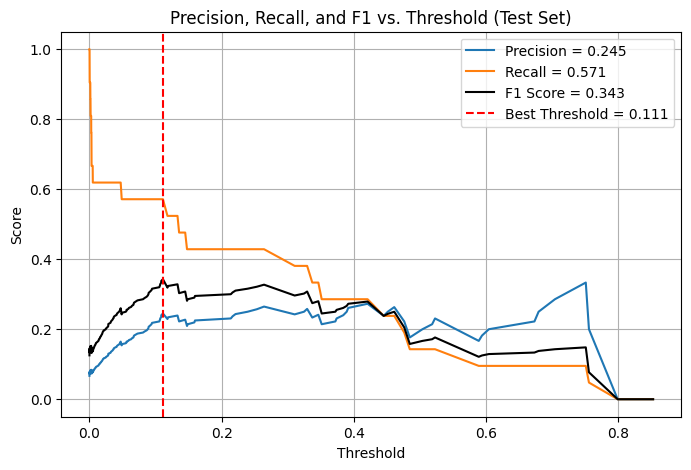

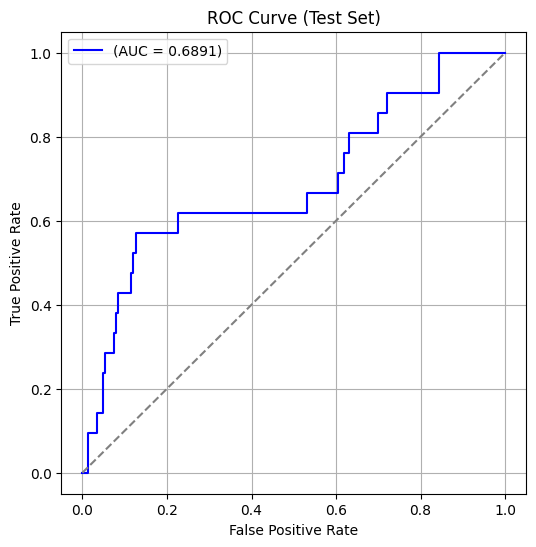

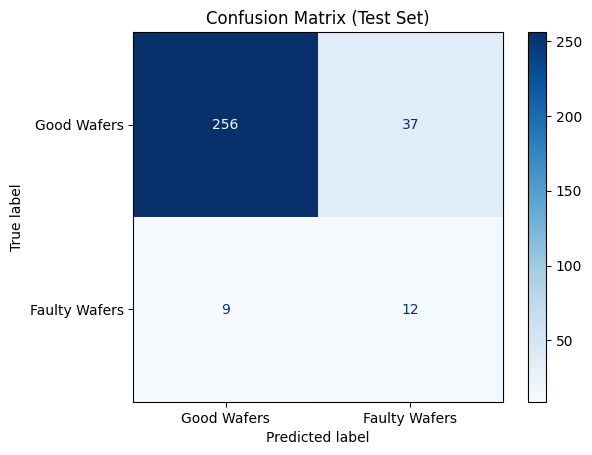

Test set evaluation metrics:
F1 Score: 0.3429
Precision: 0.2449
Recall: 0.5714
ROC-AUC: 0.6891
Best threshold for classification: 0.1112


In [ ]:
# Then call test evaluation
y_test_arr = y_test.drop(columns='date_time').values
evaluate_on_test(best_lr_pipe, X_test, y_test_arr)

In [ ]:
y_test.head()

,label,date_time
246,0,18/08/2008 04:35:00
1315,0,05/10/2008 09:47:00
444,0,24/08/2008 07:12:00
296,0,19/08/2008 08:07:00
1295,0,04/10/2008 18:25:00


## Ignore below

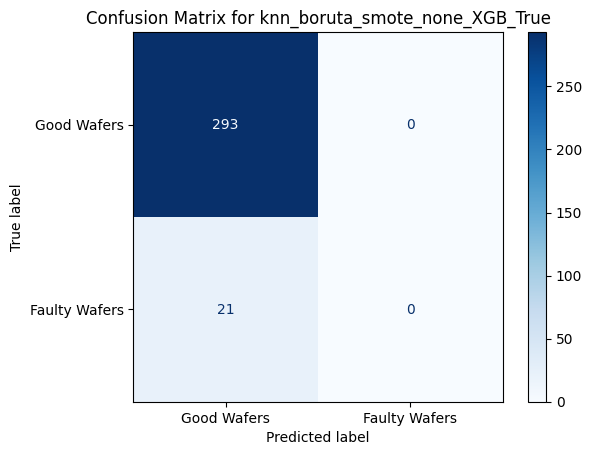

In [ ]:
best_xgb = XGBClassifier(n_estimators=225, learning_rate=0.0021672201404243393, max_depth=10, random_state=42)
#classification_report(y_test.drop(columns='date_time').values, model.fit(X_train, y_train_arr).predict(X_test))
y_pred_test = best_xgb.fit(X_train, y_train_arr).predict(X_test)
#y_test_arr = y_test.drop(columns='date_time').values
cm = confusion_matrix(y_test_arr, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good Wafers", "Faulty Wafers"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for {name}")
plt.grid(False)
plt.show()

In [ ]:
y_proba_test = final_pipe.predict_proba(X_test_boruta)[:, 1]
best_threshold = 0.478
y_pred_test = (y_proba_test >= best_threshold).astype(int)

# STEP 6: Evaluate
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
f2 = fbeta_score(y_test, y_pred_test, beta=2)
roc_auc = roc_auc_score(y_test, y_proba_test)
cm = confusion_matrix(y_test, y_pred_test)

print("\n📊 Final Evaluation on Unseen Test Set")
print(f"Threshold: {best_threshold}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"F2 Score: {f2:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print("Confusion Matrix:\n", cm)

# STEP 7: Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(cm, display_labels=["Good Wafers", "Faulty Wafers"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix @ F2 Threshold (0.478)")
plt.grid(False)
plt.tight_layout()
plt.show()